# CMIP6 trends and biases

Trends vs biases of CMIP6 models for several regions on the Antarctic continental shelf during the historical period, compared to JRA55-do

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import scipy.stats as st
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.lines import Line2D
from xarrayMannKendall import *

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:34939 Dashboard: /proxy/44473/status,Cluster Workers: 6 Cores: 24 Memory: 250.00 GiB


In [2]:
# Font size
plt.rcParams['font.size'] = 16
# Axes
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# Saving parameters
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

def change_lon_space(ds, grid):
    if grid == 'u':
        ds = ds.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    elif grid == 't':
        ds = ds.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    else:
        ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    return ds

def extract_so(ds):
    ds_so = ds.sel(lat = slice(None, -50))
    return ds_so

# Load `uas` and `vas`

In [3]:
# JRA55do-v14
uas = {}
vas = {}
uas['JRA'] = xr.open_dataset('/scratch/e14/jn8053/jra55/uas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))
vas['JRA'] = xr.open_dataset('/scratch/e14/jn8053/jra55/vas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))

# CMIP6 multimodel mean
uas['CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/uas-hist-monthly-1958_2015.nc')
vas['CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/vas-hist-monthly-1958_2015.nc')

# CMIP6 individual models
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/historical/uas/uas*')
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/historical/vas/vas*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas[model_name] = xr.open_dataset(path_uas[i])
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas[model_name] = xr.open_dataset(path_vas[i])
model_names = list(uas.keys())

# Divide by regions

In [6]:
shelf_regions = xr.open_dataset('~/g_e14/misc/Antarctic_shelf_basins.nc')
shelf_regions = change_lon_space(shelf_regions, 't')
basins = shelf_regions['basins'].where(shelf_regions['basins'] != 100, np.nan)

In [7]:
locs = list(shelf_regions['basin_lookup']['region'][:-1].values)
locs.remove('East Antarctica 04')

In [8]:
uas_reg = {}
vas_reg = {}
n = 2
for r in locs:
    for name in model_names:
        b = basins.interp(lon = uas[name]['lon'], lat = uas[name]['lat'])
        uas_reg[r, name] = uas[name]['uas'].where(b == n, np.nan).mean(['lon', 'lat'])
        b = basins.interp(lon = vas[name]['lon'], lat = vas[name]['lat']) # There is a model that has != res. for uas and vas, WEIRD
        vas_reg[r, name] = vas[name]['vas'].where(b == n, np.nan).mean(['lon', 'lat'])
    n += 1

In [9]:
high_res = ['INM-CM4-8', 'INM-CM5-0', 'FGOALS-f3-L', 'GFDL-ESM4', 'EC-Earth3-CC', 'EC-Earth3-Veg', 'EC-Earth3', 'AWI-CM-1-1-MR',
            'MPI-ESM1-2-HR', 'BCC-CSM2-MR', 'GFDL-CM4', 'MRI-ESM2-0']

legend_elements = [Line2D([0], [0], color = 'lightcoral', ls = '', marker = 'o', label = 'Higher res. CMIP6 (100km)'),
                   Line2D([0], [0], color = 'lightsteelblue', ls = '', marker = 'o', label = 'Lower res. CMIP6 (>100km)'),
                   Line2D([0], [0], color = 'k', ls = '', marker = 'o', label = 'JRA'),
                   Line2D([0], [0], color = 'k', ls = '', marker = 'x', label = 'CMIP6 mean')]

In [12]:
bias = {}
trend = {}
for r in locs:
    bias[r] = np.empty(len(model_names))
    trend[r] = np.empty(len(model_names))
    i = 0
    for name in model_names:
        bias[r][i] = (uas_reg[r, name].mean('time') - uas_reg[r, 'JRA'].mean('time')).values
        trend[r][i] = st.linregress(np.arange(0, len(uas['JRA']['time'])), uas_reg[r, name].values).slope
        i += 1

In [15]:
len(model_names)

22

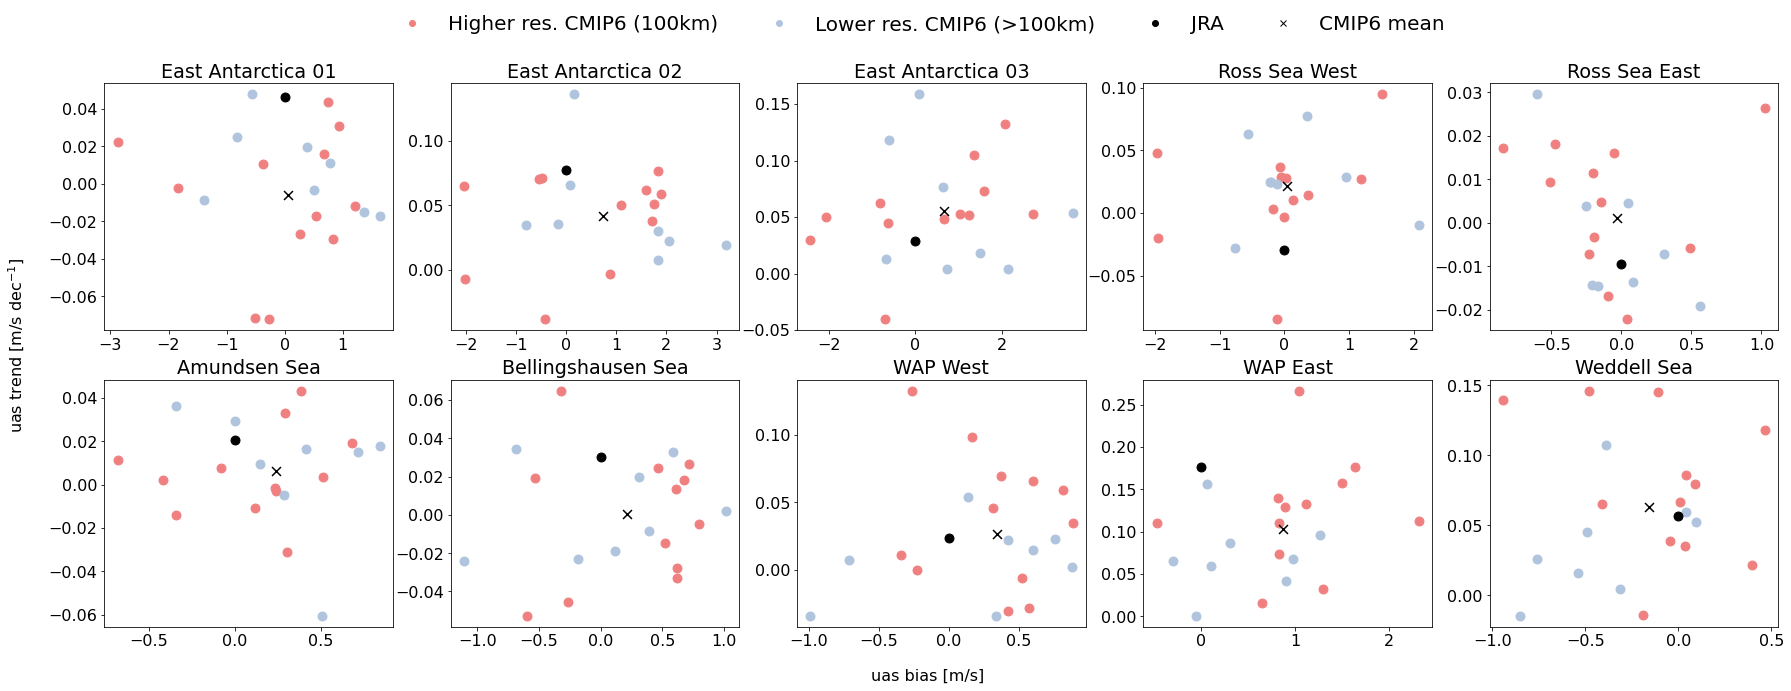

In [17]:
fig = plt.figure(figsize = (30, 10))
gr = gs.GridSpec(2, 5, figure = fig)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[0,1]), fig.add_subplot(gr[0,2]), fig.add_subplot(gr[0,3]),
       fig.add_subplot(gr[0,4]), fig.add_subplot(gr[1,0]), fig.add_subplot(gr[1,1]), fig.add_subplot(gr[1,2]),
       fig.add_subplot(gr[1,3]), fig.add_subplot(gr[1,4])]; n = 0
for r in locs:
    for i in range(20):
        if model_names[i+2] in high_res:
            axs[n].scatter(bias[r][2+i], 120*trend[r][2+i], s = 80, c = 'lightcoral', facecolor = 'none')
        else:
            axs[n].scatter(bias[r][2+i], 120*trend[r][2+i], s = 80, c = 'lightsteelblue', facecolor = 'none')
    axs[n].scatter(bias[r][0], 120*trend[r][0], s = 80, c = 'k', marker = 'o')
    axs[n].scatter(bias[r][1], 120*trend[r][1], s = 80, c = 'k', marker = 'x')
    axs[n].set_title(r)
    n+=1
fig.text(0.08, .4, 'uas trend [m/s dec$^{-1}$]', rotation = 90) 
fig.text(.48, 0.05, 'uas bias [m/s]')
fig.legend(handles = legend_elements, ncol = 4, loc = 'upper left', bbox_to_anchor = (.25, 1), fontsize = 20, frameon = False)
plt.savefig(figdir+'/easterlies-collaborative/uas-trends-biases-regions.png', facecolor = 'white', bbox_inches = 'tight')

In [18]:
bias = {}
trend = {}
for r in locs:
    bias[r] = np.empty(len(model_names))
    trend[r] = np.empty(len(model_names))
    i = 0
    for name in model_names:
        bias[r][i] = (vas_reg[r, name].mean('time') - vas_reg[r, 'JRA'].mean('time')).values
        trend[r][i] = st.linregress(np.arange(0, len(vas['JRA']['time'])), vas_reg[r, name].values).slope
        i += 1

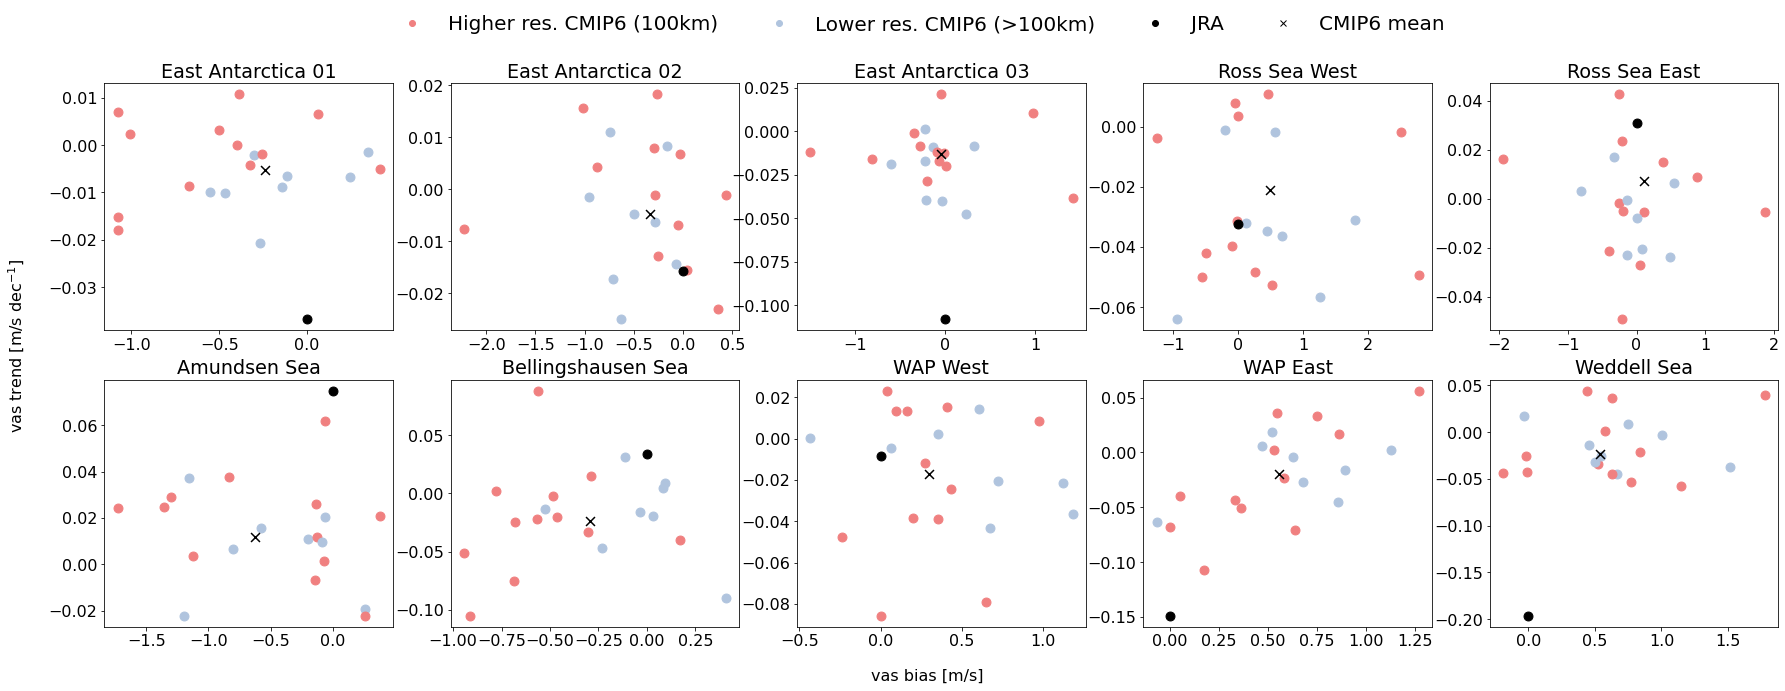

In [19]:
fig = plt.figure(figsize = (30, 10))
gr = gs.GridSpec(2, 5, figure = fig)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[0,1]), fig.add_subplot(gr[0,2]), fig.add_subplot(gr[0,3]),
       fig.add_subplot(gr[0,4]), fig.add_subplot(gr[1,0]), fig.add_subplot(gr[1,1]), fig.add_subplot(gr[1,2]),
       fig.add_subplot(gr[1,3]), fig.add_subplot(gr[1,4])]; n = 0
for r in locs:
    for i in range(20):
        if model_names[i+2] in high_res:
            axs[n].scatter(bias[r][2+i], 120*trend[r][2+i], s = 80, c = 'lightcoral', facecolor = 'none')
        else:
            axs[n].scatter(bias[r][2+i], 120*trend[r][2+i], s = 80, c = 'lightsteelblue', facecolor = 'none')
    axs[n].scatter(bias[r][0], 120*trend[r][0], s = 80, c = 'k', marker = 'o')
    axs[n].scatter(bias[r][1], 120*trend[r][1], s = 80, c = 'k', marker = 'x')
    axs[n].set_title(r)
    n+=1
fig.text(0.08, .4, 'vas trend [m/s dec$^{-1}$]', rotation = 90) 
fig.text(.48, 0.05, 'vas bias [m/s]')
fig.legend(handles = legend_elements, ncol = 4, loc = 'upper left', bbox_to_anchor = (.25, 1), fontsize = 20, frameon = False)
plt.savefig(figdir+'/easterlies-collaborative/vas-trends-biases-regions.png', facecolor = 'white', bbox_inches = 'tight')